In [132]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pickle
import copy


In [97]:
def load_batch(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f, encoding='latin1') # Nxd(3072) (Nx (32x32x3))
        X = np.transpose(dataset['data'] / 255.) # d x N
        mean_X = np.mean(X, axis=1) # mean of each row (each feature mean)
        std_X = np.std(X, axis=1)
        X = X - np.matlib.repmat(mean_X, X.shape[1], 1).T
        X = np.divide(X, np.matlib.repmat(std_X, X.shape[1], 1).T)
        
        y = np.array(dataset['labels'])
        Y = np.transpose(np.eye(X.shape[1], np.max(y) + 1)[y]) # K x N
        return X, Y, y

def load_all(validation_size):
    X_1, Y_1, y_1 = load_batch('data/data_batch_1')
    X_2, Y_2, y_2 = load_batch('data/data_batch_2')
    X_3, Y_3, y_3 = load_batch('data/data_batch_3')
    X_4, Y_4, y_4 = load_batch('data/data_batch_4')
    X_5, Y_5, y_5 = load_batch('data/data_batch_5')
    
    X = np.concatenate((X_1, X_2, X_3, X_4, X_5[:,:-validation_size]), axis=1)
    Y = np.concatenate((Y_1, Y_2, Y_3, Y_4, Y_5[:,:-validation_size]), axis=1)
    y = np.concatenate((y_1, y_2, y_3, y_4, y_5[:-validation_size]))
    
    X_valid = X_5[:,-validation_size:]
    Y_valid = Y_5[:,-validation_size:]
    y_valid = y_5[-validation_size:]
    return X, Y, y, X_valid, Y_valid, y_valid
    

In [98]:
def softmax(s):
    exponent = np.exp(s)
    return np.divide(exponent, np.sum(exponent, axis=0))

def evaluate_classifier(X, layers):
    num_layers = len(layers)
    H = []
    h_prev = X
    
    for i, layer in enumerate(layers):
        if i == num_layers - 1:  # If last layer
            P = softmax(np.dot(layer["W"], h_prev) + layer["b"]) # K x N
            return H, P
        else:
            s = np.dot(layer["W"], h_prev) + layer["b"] # m x N
            h = np.maximum(s, 0) # ReLU; m x N
            H.append(h)
            h_prev = h

In [134]:
def compute_cost(X, Y, layers, lmb):
    H, P = evaluate_classifier(X, layers)
    n = np.sum(np.multiply(Y, P), axis=0)
    cross_entropy = np.sum(-np.log(n))
    
    w_square_sum = 0
    if lmb > 0:
        for layer in layers:
            w_square_sum += np.sum(np.diag(np.dot(layer["W"].T, layer["W"])))
    return (cross_entropy / X.shape[1]) + (lmb * w_square_sum)

def compute_gradients(X, Y, layers, lmb):
    H, P = evaluate_classifier(X, layers)
    G = -(Y - P)
    Nb = X.shape[1] # batch size
    
    W_gradients = []
    b_gradients = []
    for i, layer in reversed(list(enumerate(layers))): # from last to first
        if i > 0:
            grad_W = np.divide(np.dot(G, H[i - 1].T), Nb) + (2 * lmb * layer["W"])
            grad_b = np.divide(np.dot(G, np.ones((Nb, 1))), Nb)
            G = np.dot(layer["W"].T, G)
            G = G * (H[i - 1] > 0).astype(int) # element-wise
            
            W_gradients.append(grad_W)
            b_gradients.append(grad_b)
        else: # first layer
            grad_W = np.divide(np.dot(G, X.T), Nb) + (2 * lmb * layer["W"])
            grad_b = np.divide(np.dot(G, np.ones((Nb, 1))), Nb)
            W_gradients.append(grad_W)
            b_gradients.append(grad_b)
    return W_gradients, b_gradients

    
def compute_gradients_num(X, Y, layers, lmb, h):
    
    grad_W = [np.zeros(layer["W"].shape) for layer in layers]
    grad_b = [np.zeros(layer["W"].shape[0]) for layer in layers]
    c = compute_cost(X, Y, layers, lmb)
    
    for l, layer in enumerate(layers):
        for i in range(len(layer["b"])):
            layers_try = copy.deepcopy(layers)
            layers_try[l]["b"][i] = layers_try[l]["b"][i] + h
            c2 = compute_cost(X, Y, layers_try, lmb)
            grad_b[l][i] = (c2 - c) / h

        W_shape = layer["W"].shape
        for i in range(W_shape[0]):
            for j in range(W_shape[1]):
                layers_try = copy.deepcopy(layers)
                layers_try[l]["W"][i,j] = layers_try[l]["W"][i,j] + h
                c2 = compute_cost(X, Y, layers_try, lmb)
                grad_W[l][i,j] = (c2 - c) / h
        
    return grad_W, grad_b

In [100]:
def compute_accuracy(X, y, layers):
    _, p = evaluate_classifier(X, layers)
    argmax = np.argmax(p, axis=0) # max element index of each column
    diff = argmax - y
    return (diff == 0).sum() / X.shape[1]

In [145]:
def mini_batch_GD(X, Y, GDparams, layers, lmb, validation, calculate_loss=False):
#     print("Training samples: {}".format(X.shape[1]))
#     print("Validation samples: {}".format(validation["X"].shape[1]))
#     print("Training parameters: ", GDparams)
    J_training = []
    J_validation = []
    
    eta_diff = GDparams["eta_max"] - GDparams["eta_min"]
    eta = GDparams["eta_min"]
    t = 0 # step
    l = 0 # cycle
    
    runs_in_epoch = int(X.shape[1] / GDparams["n_batch"])
    # for epoch in range(GDparams["epochs"]):
    while l < GDparams["max_cycles"]:
        for j in range(1, runs_in_epoch):
            j_start = (j - 1) * GDparams["n_batch"]
            j_end = j * GDparams["n_batch"]
            
            X_batch = X[:, j_start:j_end]
            Y_batch = Y[:, j_start:j_end]
            
            grad_W, grad_b = compute_gradients(X_batch, Y_batch, layers, lmb)
            
            for i, layer in enumerate(layers):
                layer["W"] = layer["W"] - (eta * grad_W[-1 - i])
                layer["b"] = layer["b"] - (eta * grad_b[-1 - i])
        
            if calculate_loss and t % 100 == 0:
                J_training.append(compute_cost(X, Y, layers, lmb))
                J_validation.append(compute_cost(validation["X"], validation["Y"], layers, lmb))
                print("Step {}, training loss: {}".format(t, J_training[-1]))
                
            t += 1 # next update step
            if t % (2 * GDparams["n_s"]) == 0:
                l += 1 # next cycle
                if l == GDparams["max_cycles"]:
                    break
#                 print("Entering cycle {}, t: {}, eta: {}".format(l, t, eta))
            if t <= (2*l + 1) * GDparams["n_s"]:
                eta = GDparams["eta_min"] + (eta_diff * ((t - (2 * l * GDparams["n_s"])) / GDparams["n_s"]))
            else:
                eta = GDparams["eta_max"] - (eta_diff * (t - ((2*l + 1) * GDparams["n_s"])) / GDparams["n_s"])

    if calculate_loss:
        return layers, J_training, J_validation
    else:
        return layers

In [146]:
X, Y, y = load_batch('data/data_batch_1')
X_valid, Y_valid, y_valid = load_batch('data/data_batch_2')
# X, Y, y, X_valid, Y_valid, y_valid = load_all(validation_size=1000)
X_test, Y_test, y_test = load_batch('data/test_batch')

d = X.shape[0]
N = X.shape[1]
K = Y.shape[0]

# X: d x N
# Y: K x N

m = 50 # hidden units

std_dev_1 = 1 / np.sqrt(d)
std_dev_2 = 1 / np.sqrt(m)
# W_1 = std_dev * np.random.randn(m, d)
# b_1 = std_dev * np.random.randn(m, 1)

# W_2 = std_dev * np.random.randn(K, m)
# b_2 = std_dev * np.random.randn(K, 1)
def init_network(dimensions=d):
    layers = [
        {
            "W": std_dev_1 * np.random.randn(m, dimensions),
            "b": np.zeros((m, 1)),
        },
        {
            "W": std_dev_2 * np.random.randn(K, m),
            "b": np.zeros((K, 1)),
        },
    ]
    return layers


lmb = 0.01  # lambda
GDparams = {
    "n_batch": 100,
    "eta_min": 1e-5,
    "eta_max": 1e-1,
    "n_s": 500,
    "epochs": 10,
    "max_cycles": 1,
}
#     "n_s": 2 * np.floor(X.shape[1] / 100),
validation = {
    "X": X_valid,
    "Y": Y_valid,
}

print(GDparams)

{'n_batch': 100, 'eta_min': 1e-05, 'eta_max': 0.1, 'n_s': 500, 'epochs': 10, 'max_cycles': 1}


Step 0, training loss: 3.0498819193072886
Step 100, training loss: 2.392219359086213
Step 200, training loss: 2.168125606456703
Step 300, training loss: 1.9972024663667383
Step 400, training loss: 1.8961340311327568
Step 500, training loss: 1.9102659598526244
Step 600, training loss: 1.7218119718439329
Step 700, training loss: 1.5877481266918752
Step 800, training loss: 1.5396933653858766
Step 900, training loss: 1.4785447861802798


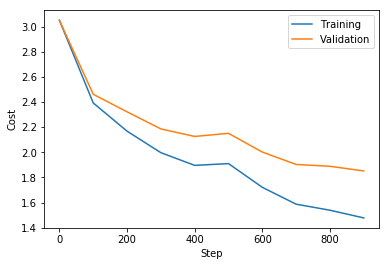

Test cost:  1.8086210412224772
Test accuracy:  0.4591


In [147]:
layers = init_network()
layers_trained, J_training, J_validation = mini_batch_GD(X, Y, GDparams, layers, lmb, validation, calculate_loss=True)
test_cost = compute_cost(X_test, Y_test, layers_trained, lmb)
test_acc = compute_accuracy(X_test, y_test, layers_trained)

plt.figure(0)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.plot([step*100 for step in range(len(J_training))], J_training, label="Training")
plt.plot([step*100 for step in range(len(J_validation))], J_validation, label="Validation")
plt.legend()
plt.show()

print("Test cost: ", test_cost)
print("Test accuracy: ", test_acc)

In [144]:

feature_dims = 20
samples = 1

layers_g = init_network(dimensions=feature_dims)
X_g = X[0:feature_dims, 0:samples] #d X N
Y_g = Y[:, 0:samples] #K x N

grad_W, grad_b = compute_gradients(X_g, Y_g, layers_g, lmb=0)
ngrad_w, ngrad_b = compute_gradients_num(X_g, Y_g, layers_g, lmb=0, h=1e-5)
print("\ngrad b:")

print(np.abs(grad_b[1].T - ngrad_b[0]) / np.maximum(1e-5, np.abs(grad_b[1].T) + np.abs(ngrad_b[0])))
print(np.abs(grad_b[0].T - ngrad_b[1]) / np.maximum(1e-5, np.abs(grad_b[0].T) + np.abs(ngrad_b[1])))

print("\ngrad W:")
print(np.abs(grad_W[1] - ngrad_w[0]) / np.maximum(1e-5, np.abs(grad_W[1]) + np.abs(ngrad_w[0])))
print(np.abs(grad_W[0] - ngrad_w[1]) / np.maximum(1e-5, np.abs(grad_W[0]) + np.abs(ngrad_w[1])))



grad b:
[[7.22620921e-07 2.04477735e-07 3.43940661e-07 0.00000000e+00
  0.00000000e+00 3.72885493e-07 9.81260112e-07 0.00000000e+00
  1.33911573e-07 0.00000000e+00 1.17774690e-06 0.00000000e+00
  1.61974647e-07 0.00000000e+00 0.00000000e+00 2.08629169e-07
  2.47794232e-07 0.00000000e+00 0.00000000e+00 2.63721484e-07
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.06335476e-06
  7.58853713e-06 0.00000000e+00 1.84199899e-07 0.00000000e+00
  3.88413830e-07 1.51827259e-07 4.25479314e-07 2.83864730e-07
  1.86711403e-07 0.00000000e+00 0.00000000e+00 1.77481971e-07
  4.80183069e-07 0.00000000e+00 0.00000000e+00 3.44832166e-07
  3.02360513e-07 4.48643963e-07 1.77797009e-07 0.00000000e+00
  0.00000000e+00 3.70674027e-07 3.82788220e-07 3.24558295e-07
  1.20987290e-07 0.00000000e+00]]
[[2.24521925e-06 2.26164420e-06 2.23953034e-06 2.24687523e-06
  2.24781743e-06 2.25052211e-06 2.47856810e-07 2.25262913e-06
  2.25260408e-06 2.25075809e-06]]

grad W:
[[7.15282834e-07 8.76597861e-07 8.19188144e-07

In [43]:
# Searching for lambda (coarse)
l_min = -7
l_max = -0.5

ls = np.sort([np.random.uniform(l_min, l_max) for i in range(40)])
for l in ls:
    lmb = np.power(10, l)
    layers = init_network()
    layers_trained = mini_batch_GD(X, Y, GDparams, layers, lmb, validation)
    test_cost = compute_cost(X_test, Y_test, layers_trained, lmb)
    test_acc = compute_accuracy(X_test, y_test, layers_trained)
    print("Lambda: {} (l: {}), test cost: {}, test accuracy: {}".format(lmb, l, test_cost, test_acc))


Lambda: 1.6284587893989866e-07 (l: -6.788223227435661), test cost: 1.3955476758729672, test accuracy: 0.5132
Lambda: 1.9433438313018646e-07 (l: -6.711450353889899), test cost: 1.3919308043169243, test accuracy: 0.517
Lambda: 3.056436545874993e-07 (l: -6.514784616089612), test cost: 1.3939520376447685, test accuracy: 0.5142
Lambda: 3.5712004431965055e-07 (l: -6.447185773181305), test cost: 1.4108065471022475, test accuracy: 0.5093
Lambda: 7.390586553404944e-07 (l: -6.131321092484978), test cost: 1.4068398276676728, test accuracy: 0.5086
Lambda: 8.521334979178329e-07 (l: -6.069492361961749), test cost: 1.4000591986331568, test accuracy: 0.5107
Lambda: 8.997257824166672e-07 (l: -6.045889834260329), test cost: 1.404094918824293, test accuracy: 0.509
Lambda: 1.681239486847397e-06 (l: -5.774370418381956), test cost: 1.404773911688305, test accuracy: 0.5098
Lambda: 2.3633480660796677e-06 (l: -5.626472312203524), test cost: 1.4111979526545093, test accuracy: 0.5052
Lambda: 5.772363874301318e-0

In [44]:
# Searching for lambda (fine)
l_min = -3.2
l_max = -2.2

ls = np.sort([np.random.uniform(l_min, l_max) for i in range(40)])
for l in ls:
    lmb = np.power(10, l)
    layers = init_network()
    layers_trained = mini_batch_GD(X, Y, GDparams, layers, lmb, validation)
    test_cost = compute_cost(X_test, Y_test, layers_trained, lmb)
    test_acc = compute_accuracy(X_test, y_test, layers_trained)
    print("Lambda: {} (l: {}), test cost: {}, test accuracy: {}".format(lmb, l, test_cost, test_acc))


Lambda: 0.00071248749330148 (l: -3.1472227546707865), test cost: 1.4510756984427802, test accuracy: 0.5099
Lambda: 0.0007146232764639532 (l: -3.1459228422124754), test cost: 1.445761949523194, test accuracy: 0.5136
Lambda: 0.0007259585887334052 (l: -3.13908815229924), test cost: 1.4462508747087506, test accuracy: 0.5177
Lambda: 0.0007782678867742624 (l: -3.108870889228044), test cost: 1.4491521275418415, test accuracy: 0.5154
Lambda: 0.0008077652925526167 (l: -3.0927148112015628), test cost: 1.4508162866347136, test accuracy: 0.5143
Lambda: 0.0008796213601880293 (l: -3.0557042330411712), test cost: 1.4647637385936567, test accuracy: 0.5118
Lambda: 0.0009808860205645364 (l: -3.008381454919501), test cost: 1.4525600055983214, test accuracy: 0.5156
Lambda: 0.0010307469960792377 (l: -2.9868479221954005), test cost: 1.4731967662924745, test accuracy: 0.5118
Lambda: 0.0010696752797705368 (l: -2.9707480406390325), test cost: 1.4638358700561023, test accuracy: 0.5148
Lambda: 0.0010802928782016

In [106]:
best_ls = [-3.13908815229924, -2.8917374991280846, -2.325238114712273]
for l in best_ls:
    lmb = np.power(10, l)
    layers = init_network()
    layers_trained = mini_batch_GD(X, Y, GDparams, layers, lmb, validation)
    test_cost = compute_cost(X_test, Y_test, layers_trained, lmb)
    test_acc = compute_accuracy(X_test, y_test, layers_trained)

    print("\nTest cost: {}".format(test_cost))
    print("Test accuracy: {}".format(test_acc))


Test cost: 1.4662692267907325
Test accuracy: 0.5033

Test cost: 1.4734380766557735
Test accuracy: 0.5091

Test cost: 1.5240595621558624
Test accuracy: 0.5113


In [110]:
# Best
lmb = np.power(10, -2.325238114712273)
layers = init_network()
layers_trained, J_training, J_validation = mini_batch_GD(X, Y, GDparams, layers, lmb, validation, calculate_loss=True)
test_cost = compute_cost(X_test, Y_test, layers_trained, lmb)
test_acc = compute_accuracy(X_test, y_test, layers_trained)

Step 100, training loss: 2.253172992125316
Step 200, training loss: 2.100325195655345
Step 300, training loss: 1.9737706802614237
Step 400, training loss: 1.8961855549736484
Step 500, training loss: 1.843433465359997
Step 600, training loss: 1.8288526175755262
Step 700, training loss: 1.7581627038417929
Step 800, training loss: 1.7836182100101226
Step 900, training loss: 1.764136539898768
Step 1000, training loss: 1.6800498207387053
Step 1100, training loss: 1.6835408784970007
Step 1200, training loss: 1.6182474516372258
Step 1300, training loss: 1.5944575005846007
Step 1400, training loss: 1.5713009756287717
Step 1500, training loss: 1.5531934641492364
Step 1600, training loss: 1.536922642582774
Step 1700, training loss: 1.4926557596758074
Step 1800, training loss: 1.4814746398043157
Step 1900, training loss: 1.4640033002828519
Step 2000, training loss: 1.4590025017293484
Step 2100, training loss: 1.463748985207479
Step 2200, training loss: 1.4755525499033917
Step 2300, training loss:

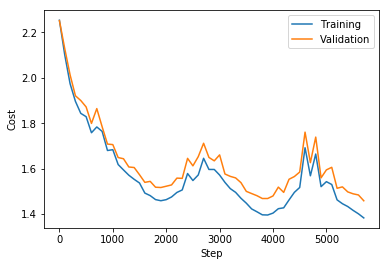

Test cost:  1.5004219023178478
Test accuracy:  0.5203


In [111]:
plt.figure(0)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.plot([step*100 for step in range(len(J_training))], J_training, label="Training")
plt.plot([step*100 for step in range(len(J_validation))], J_validation, label="Validation")
plt.legend()
plt.show()

print("Test cost: ", test_cost)
print("Test accuracy: ", test_acc)

In [37]:
plt.figure(1)
for i, j in enumerate(layers_trained["W"]):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.rot90(np.reshape((j - j.min()) / (j.max() - j.min()), (32, 32, 3), order='F'), k=3))
    plt.axis("off")
plt.show()

TypeError: list indices must be integers or slices, not str

<Figure size 432x288 with 0 Axes>

In [261]:
a = np.array([[1,-2,3], [-3, 2, -1]])
print(np.maximum(a, 0))

[[1 0 3]
 [0 2 0]]
